In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

### Multivariate Gaussian Example

### per hand

## Closed-form posterior
For a 2-dimensional Gaussian prior with mean $\mu_0$ and covariance $\Sigma_0$ and data with mean $\bar{x}$ and covariance $\Sigma$ (generated by sampling from a 2-dimensional Gaussian, whose variance we assume to be known), the posterior parameters can be derived in closed form (https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf):

$$ \Sigma_N = (\Sigma_0^{-1} + N \Sigma^{-1})^{-1}$$
$$ \mu_N = \Sigma_N (N \Sigma^{-1} \bar{x} + \Sigma_0^{-1} \mu_0) $$

In [2]:
# data parameters
mu = np.array([5.0, 7.0])
sigma = np.array([[2,0.5],[0.5,1]])
N = 10

# generate some data
x = np.random.multivariate_normal(mu, sigma, N)

In [3]:
# prior parameters

mu0 = np.array([4.0, 4.0])
sigma0 = np.array([[1,-0.5],[-0.5,0.7]])
prior_mu =  pyabc.Prior('multivariate_gaussian', mu0, sigma0)

def simulator(mu1, mu2):
    sigma = np.array([[2,0.5],[0.5,1]])
    return np.random.multivariate_normal(np.array([mu1, mu2]), sigma, 10)

simulator(*prior_mu.sample())

array([[ 4.68896702,  4.26659413],
       [ 7.21087519,  4.83979535],
       [ 6.56080305,  5.40783499],
       [ 6.08129801,  4.6032346 ],
       [ 5.14299499,  5.3079142 ],
       [ 6.71802279,  6.19348595],
       [ 6.61929452,  4.56604222],
       [ 4.5648593 ,  5.75062558],
       [ 3.2808832 ,  3.25974955],
       [ 7.11500264,  7.74876083]])

In [4]:
# distance measure between sufficient statistics of two data sets
def mean(x):
    return np.mean(x, 0)


def cov(x):
    return np.cov(x.T)

def bhatt(s1, s2):
    mu1 = np.array([s1[0], s1[1]])
    sigma1 = np.array([[s1[2], s1[3]], [s1[4], s1[5]]])
    
    mu2 = np.array([s2[0], s2[1]])
    sigma2 = np.array([[s2[2], s2[3]], [s2[4], s2[5]]])
    # compute sufficient statistics (mean and covariance)
    sigma = 0.5 * (sigma1 + sigma2)
    da = 0.125 * (mu1 - mu2).T @ np.linalg.inv(sigma) @ (mu1 - mu2)
    db = 0.5 * np.log(np.linalg.det(sigma) / np.sqrt(np.linalg.det(sigma1) * np.linalg.det(sigma2)))
    return da + db

In [5]:
rej_samp = pyabc.RejectionSampler(
    priors=prior_mu,
    simulator=simulator,
    summaries=[mean, cov],
    distance=bhatt,
    observation=x
)

In [10]:
rej_samp.sample(threshold=0.2, nr_samples=1000)

Rejection sampler started with threshold: 0.2 and number of samples: 1000
Samples:   1000 - Threshold: 0.20 - Number of iterations:      41000 - Time:    12.80 s


<IPython.core.display.Javascript object>


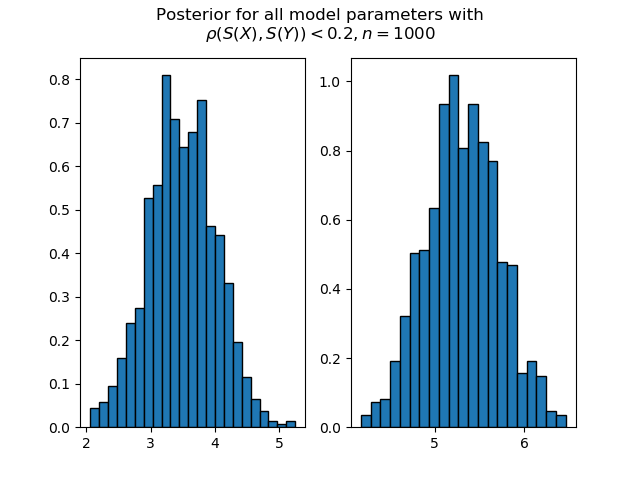

In [11]:
rej_samp.plot_marginals()